
# FiftyOne Workshop: Clustering and Labeling with Embeddings (March 12th 2025)

In this notebook, we will explore how to use **embeddings** to cluster and assign labels to dataset samples.
This technique is valuable when dealing with unlabeled datasets or when refining existing labels.

![Image](https://github.com/user-attachments/assets/fc17ccb3-d936-4c9e-b344-ae1d3d0a8c84)

## 🏆 Learning Objectives:
- Understand clustering techniques and their role in dataset labeling.
- Compute embeddings and cluster dataset samples.
- Use FiftyOne Plugin for clustering MVTec dataset
- Use FiftyOne for visualization and dataset management.

---



## 📌 Why Use Clustering for Labeling?

Labeling datasets manually is expensive and time-consuming. **Clustering** helps by automatically grouping similar samples based on embeddings.
This method is useful for:
- **Unsupervised Learning**: Automatically discovering patterns in unlabeled data.
- **Dataset Cleanup**: Detecting mislabeled samples.
- **Efficient Annotation**: Pre-labeling groups for human annotators.

Common clustering techniques include:
- **K-Means** (partition-based clustering)
- **DBSCAN** (density-based clustering)
- **Hierarchical Clustering** (tree-based grouping)

### 🔗 Further Reading:
- [Clustering in Machine Learning](https://en.wikipedia.org/wiki/Cluster_analysis)
- [Introduction to Unsupervised Learning](https://towardsdatascience.com/a-guide-to-clustering-algorithms-e28af85da0b7/#:~:text=Clustering%20is%20an%20unsupervised%20Machine,and%20even%20some%20use%20cases.)


## Requirement step: Remove Category Labels (Keep Only Defects)

Since category labels in your dataset are stored as `category.label`, you can remove them like is showing in the following cell. This removes all `category.label` fields from the dataset while keeping `defect.label`.

In [1]:
import fiftyone as fo
import fiftyone.utils.huggingface as fouh # Hugging Face integration

# Load dataset
dataset = fouh.load_from_hub("Voxel51/mvtec-ad", persistent=True, overwrite=True)
#dataset = fo.load_dataset("Voxel51/mvtec-ad") # Use this CLI if you already have the dataset 
                                               # in your disk or if this is not the first time you run this notebook 

# Iterate over samples and remove category labels
for sample in dataset:
    sample["category"] = None  # Remove category classification
    sample.save()

print("✅ All category labels removed. Only defect labels remain.")


Loading dataset
Importing samples...
 100% |███████████████| 5354/5354 [62.2ms elapsed, 0s remaining, 86.1K samples/s]   
Migrating dataset 'Voxel51/mvtec-ad' to v1.3.0
✅ All category labels removed. Only defect labels remain.


In [2]:
print(dataset.last())

<Sample: {
    'id': '6621d76a324f6e05d5838ef7',
    'media_type': 'image',
    'filepath': '/Users/paularamos/fiftyone/huggingface/hub/Voxel51/mvtec-ad/data/data_53/009-101.png',
    'tags': [],
    'metadata': None,
    'created_at': datetime.datetime(2024, 4, 19, 2, 31, 6),
    'last_modified_at': datetime.datetime(2025, 3, 4, 13, 43, 31, 811881),
    'category': None,
    'defect': <Classification: {
        'id': '6621d769324f6e05d5837a0c',
        'tags': [],
        'label': 'thread',
        'confidence': None,
        'logits': None,
    }>,
    'split': 'test',
    'defect_mask': <Segmentation: {
        'id': '6621d769324f6e05d5837a0d',
        'tags': [],
        'mask': None,
        'mask_path': '/Users/paularamos/fiftyone/huggingface/hub/Voxel51/mvtec-ad/fields/defect_mask/defect_mask_12/009_mask-71.png',
    }>,
}>



## 📥 Generating Embeddings

Before clustering, we must **generate embeddings** that capture meaningful feature representations.
FiftyOne provides multiple ways to obtain embeddings:
- **Using pre-trained models** from FiftyOne's Model Zoo (e.g., CLIP, ResNet).
- **Extracting embeddings from custom models** (e.g., OpenAI, Anomalib, or self-trained networks).

```python
import fiftyone.zoo as foz

model = foz.load_zoo_model("open-clip-vit-base32-torch")

# Compute embeddings
fob.compute_visualization(dataset, model=model, embeddings=...)
```

🔗 **Relevant Documentation:** [Computing Embeddings in FiftyOne](https://voxel51.com/docs/fiftyone/user_guide/brain.html#computing-embeddings)


In [3]:
import fiftyone.brain as fob
import fiftyone.zoo.models as fozm

# Load a pretrained model (e.g., CLIP)
model = fozm.load_zoo_model("clip-vit-base32-torch")

# Compute embeddings for the dataset
fob.compute_visualization(
    dataset,
    model=model,
    embeddings="clip_embeddings",
    method="umap",
    brain_key="clip_vis",
    batch_size=10
)

print("✅ Embeddings computed.")


Computing embeddings...
 100% |███████████████| 5354/5354 [2.4m elapsed, 0s remaining, 46.5 samples/s]      
Generating visualization...


/Users/paularamos/Documents/fiftyone_CVPR/py311_anomalib200b3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP( verbose=True)
Tue Mar  4 08:48:23 2025 Construct fuzzy simplicial set
Tue Mar  4 08:48:23 2025 Finding Nearest Neighbors
Tue Mar  4 08:48:23 2025 Building RP forest with 9 trees
Tue Mar  4 08:48:25 2025 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	Stopping threshold met -- exiting after 3 iterations
Tue Mar  4 08:48:29 2025 Finished Nearest Neighbor Search
Tue Mar  4 08:48:30 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Mar  4 08:48:31 2025 Finished embedding
✅ Embeddings computed.


In [4]:
dataset.reload()
print(dataset)
print(dataset.last())

Name:        Voxel51/mvtec-ad
Media type:  image
Num samples: 5354
Persistent:  True
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    category:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    defect:           fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    split:            fiftyone.core.fields.StringField
    defect_mask:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Segmentation)
    clip_embeddings:  fiftyone.core.fields.VectorField
<Sample: {
    'id': '6621d76a324f6e05d5838ef7',
    '

In [5]:
session = fo.launch_app(dataset)

Connected to FiftyOne on port 5151 at localhost.
If you are not connecting to a remote session, you may need to start a new session and specify a port



## 🔍 Clustering Dataset Samples with a FiftyOne Plugin

Once we have embeddings, we can **cluster dataset samples** based on similarity. the theory around that it not complex but it could take some time for running and testing what do you want to do. For Example for clustering samples by similarity you maybe need to use the following code: 

Example using **K-Means Clustering**:
```python
from sklearn.cluster import KMeans

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)
```

After clustering, we can assign labels to our dataset:

```python
import fiftyone as fo

# Assign clustering results to FiftyOne dataset
for sample, label in zip(dataset, cluster_labels):
    sample["cluster"] = int(label)  # Store as an integer field
    sample.save()
```

## 📟 But, What if I teel you you don't need to write a code for doing that

FiftyOne provides an extensible plugin system that allows users to enhance their workflows with additional functionalities, such as dataset visualization, embeddings analysis, and automated clustering. A FiftyOne Plugin is a modular component that extends the capabilities of the FiftyOne UI or backend. These plugins can be used for various tasks, including visualization, dataset processing, and machine learning model integration.

#### Clustering Plugin in FiftyOne
One powerful plugin available in FiftyOne is the Clustering Plugin, which allows users to group similar samples together based on embeddings. This is useful for tasks like:
- Understanding patterns in your dataset
- Identifying redundant or mislabeled data
- Grouping anomalies or outliers

🔗 **Relevant Documentation:**  
- [Clustering Algorithms](https://en.wikipedia.org/wiki/Cluster_analysis)  
- [FiftyOne Dataset Fields](https://docs.voxel51.com/user_guide/using_datasets.html#fields)
- [FiftyOne Clustering Plugin](https://github.com/jacobmarks/clustering-plugin)


## Install the Clustering Plugin

Just using:

```
fiftyone plugins download https://github.com/jacobmarks/clustering-plugin
```

You can see how FiftyOne App allows you to cluster your dataset using a variety of algorithms: [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans), [Birch](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html#sklearn.cluster.Birch), [Agglomerative](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering), [HDBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.HDBSCAN). It also serves as a proof of concept for adding new "types" of runs to FiftyOne!!!

You will also need to have `scikit-learn` installed:

In [ ]:
#!fiftyone plugins download https://github.com/jacobmarks/clustering-plugin
#!pip install -U scikit-learn

  162.8Kb [7.6ms elapsed, ? remaining, 20.8Mb/s]    
Skipping existing plugin '@jacobmarks/clustering'



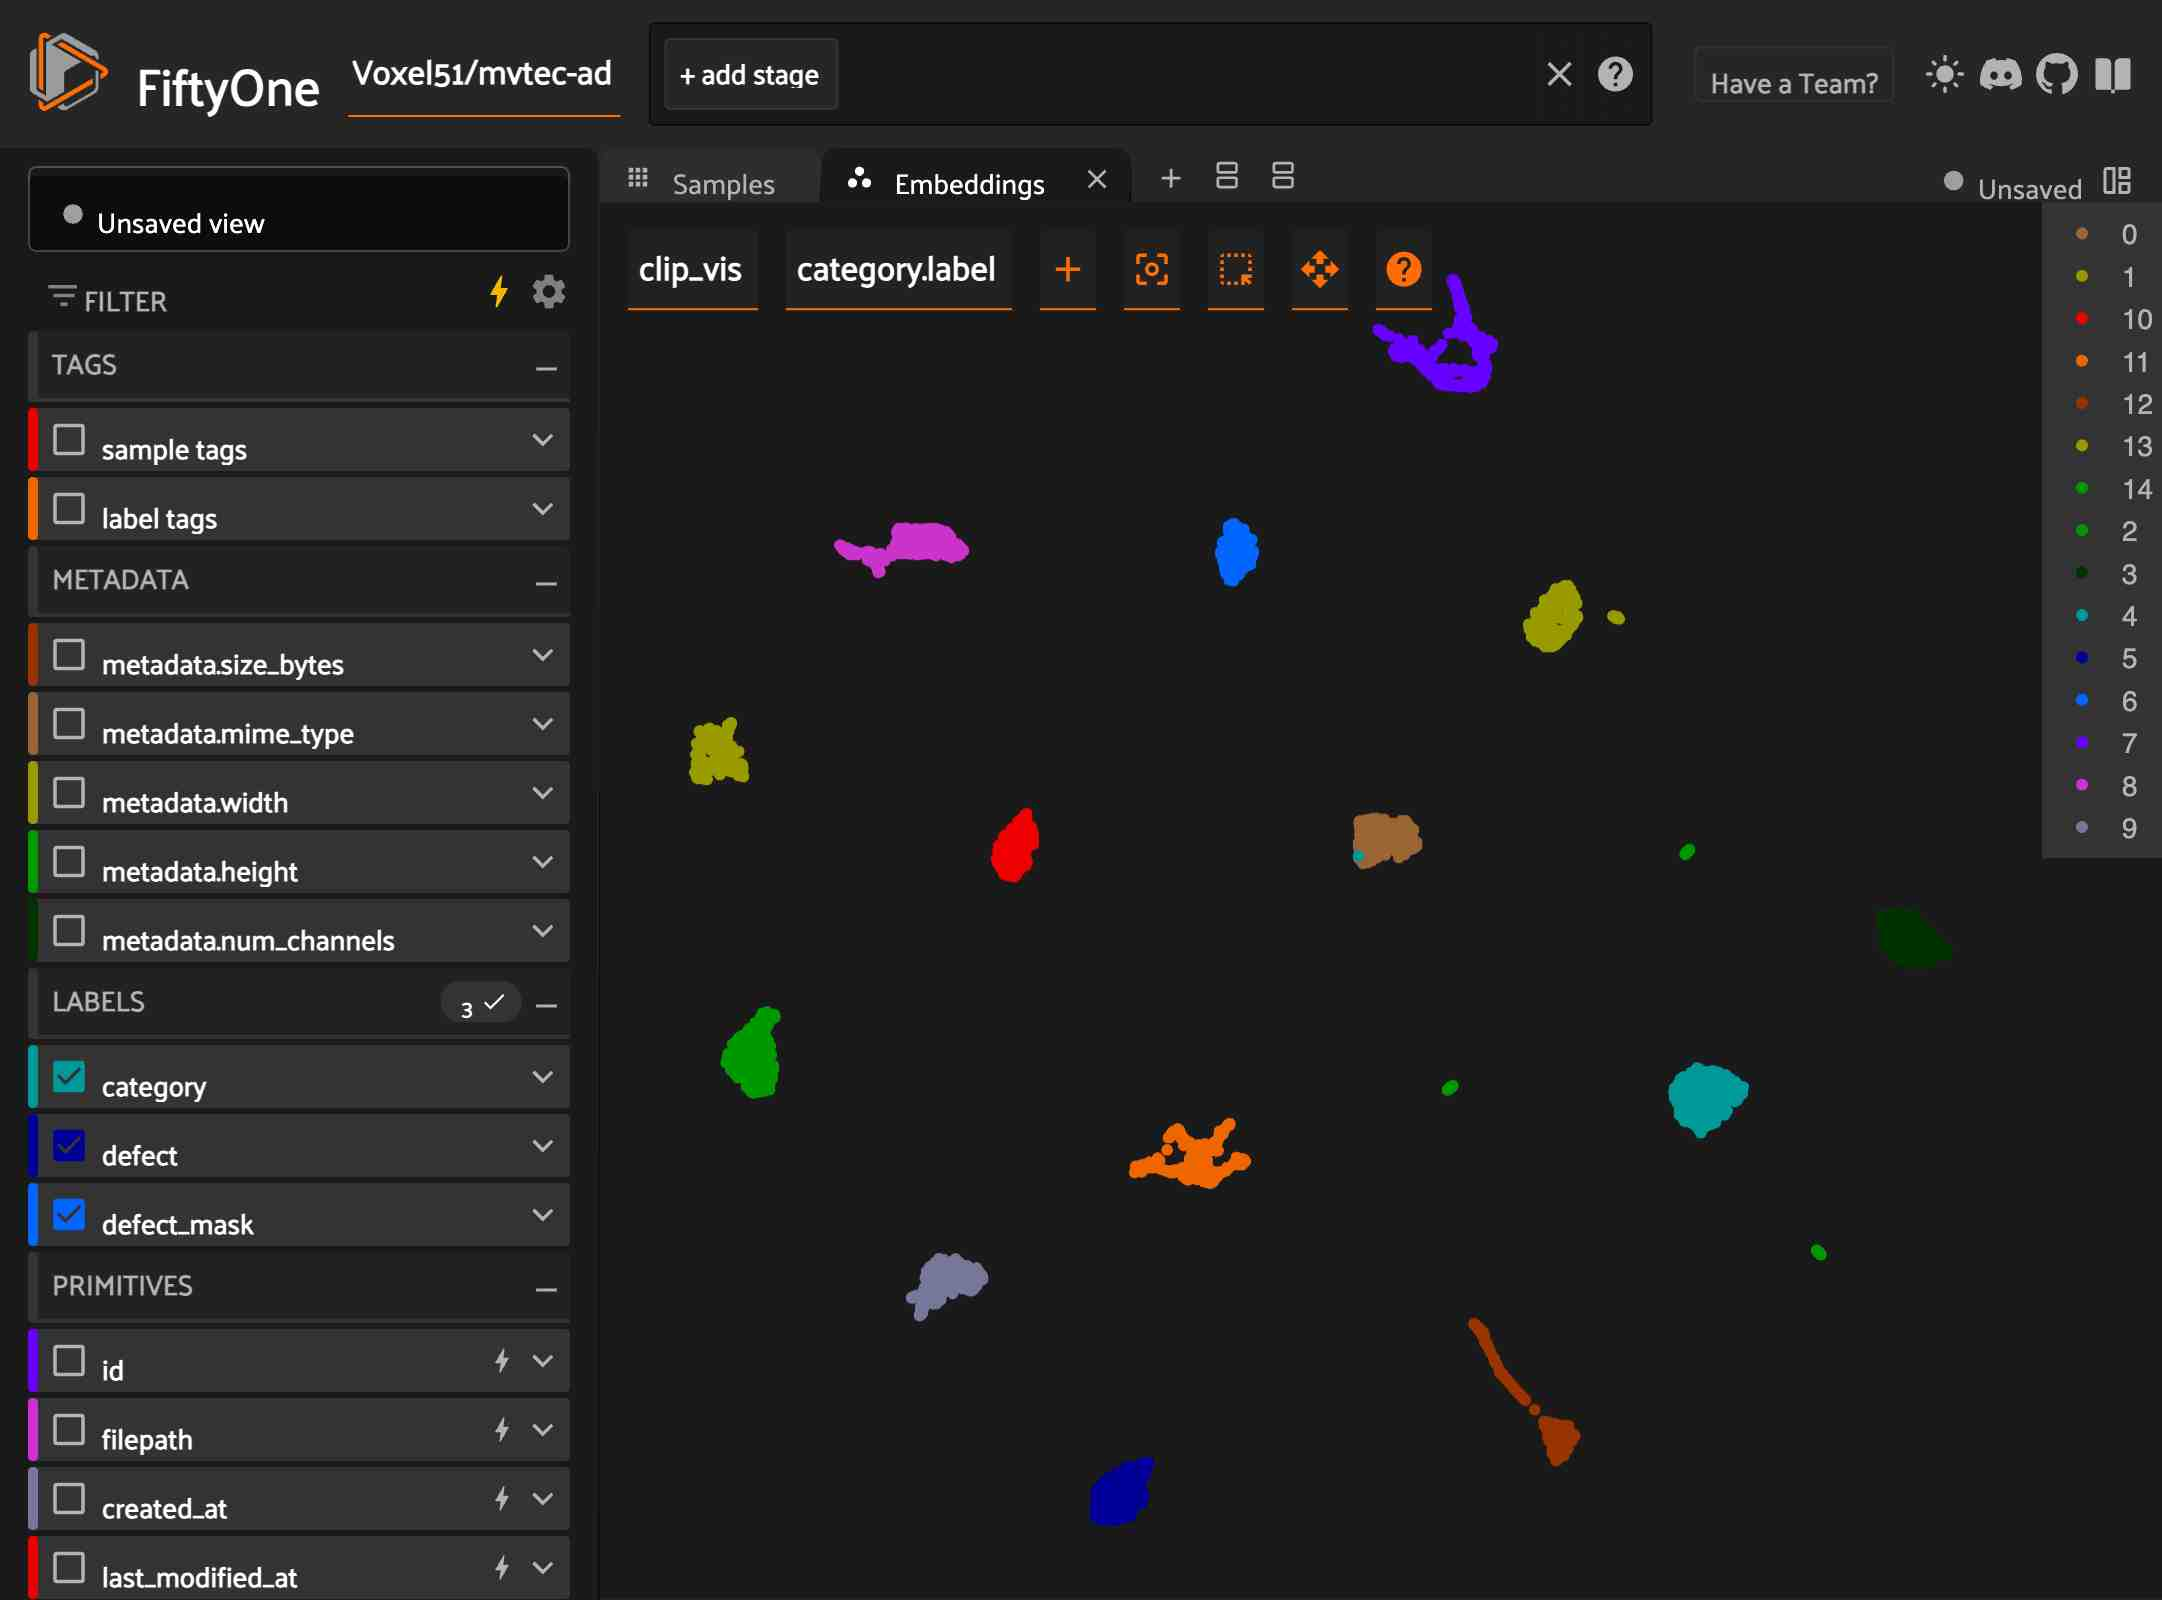

In [ ]:
session = fo.launch_app(dataset)

[![Watch the video](https://github.com/user-attachments/assets/72a20cc7-6e67-420c-90c3-0f7b424f859f)](https://github.com/paularamo/awesome-fiftyone/blob/main/getting-started-90min-workshop/sources/clustering_video.mp4)



### Next Steps:
Try experimenting with different clustering methods (e.g., HDBSCAN, Birch clustering) and evaluate their impact on labeling quality! 🚀

🔗 **More Resources:**  
- [FiftyOne Docs](https://voxel51.com/docs/fiftyone/)  
- [FiftyOne Tutorials](https://voxel51.com/docs/fiftyone/tutorials/index.html)
